# ClimateNet AR Analysis: MERRA data

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl

In [ ]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
# 5 GB was fine for western US but ran into memory issues for western Europe...due to extra rolling step to fix lons?
nmem1 = '10GiB' # PBSCluster specification
nmem2 = '10GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/derecho/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ext', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
#dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/42339/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/42339/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.97:36401,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/42339/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Set MERRA ARs path

In [64]:
merra_cnet_path = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier1/ClimateNet_DL/' # tier1, 3hrly
#merra_cnet_path = '/glade/derecho/scratch/shields/ARTMIP/catalogues/tier2/MERRA2_native/climatenet/' # tier2, 1hrly

In [65]:
#file_years = '*.20[00-15]*' # not a perfect wildcard, but captures 2000 - 2017 (or 2019 for tier2)
file_years = '*.nc4' # for all years; 1980 - June 2017

## Read in data

In [66]:
merra_cnet = xr.open_mfdataset(merra_cnet_path+file_years, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True)
merra_cnet

<xarray.Dataset>
Dimensions:        (time: 109568, lat: 361, lon: 576)
Coordinates:
  * lat            (lat) float32 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon            (lon) float32 -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * time           (time) datetime64[ns] 1980-01-01 ... 2017-06-30T21:00:00
Data variables:
    ar_binary_tag  (time, lat, lon) int8 dask.array<chunksize=(500, 361, 576), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...
    history:      Thu Oct  1 09:37:20 2020: ncatted -O -a long_name,time,c,c,...
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...

In [67]:
merra_ar_full = merra_cnet.ar_binary_tag
merra_ar_full

<xarray.DataArray 'ar_binary_tag' (time: 109568, lat: 361, lon: 576)>
dask.array<concatenate, shape=(109568, 361, 576), dtype=int8, chunksize=(500, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 1980-01-01 ... 2017-06-30T21:00:00
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  binary indicator of atmospheric river

In [68]:
# subset 2000-2015 to match CESM years (number of time indices will not match due to CESM shifted start and MERRA leap years)
#merra_ar = merra_ar_full.sel(time=slice("2000","2015"))

# or look at all years
merra_ar = merra_ar_full

merra_ar

<xarray.DataArray 'ar_binary_tag' (time: 109568, lat: 361, lon: 576)>
dask.array<concatenate, shape=(109568, 361, 576), dtype=int8, chunksize=(500, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time     (time) datetime64[ns] 1980-01-01 ... 2017-06-30T21:00:00
Attributes:
    version:      CGNet
    scheme:       ClimateNet_DL_model
    description:  binary indicator of atmospheric river

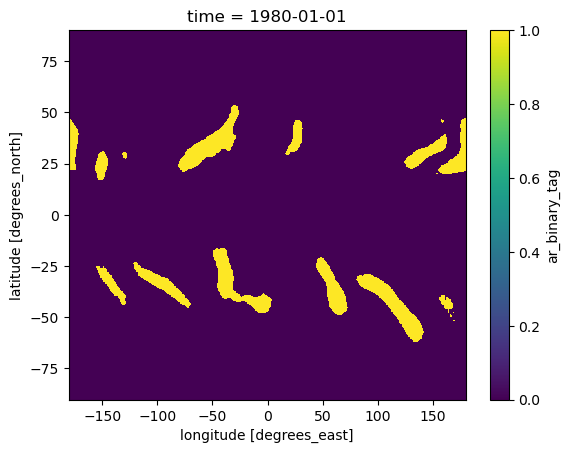

In [69]:
merra_ar.isel(time=0).plot();

## Global AR frequency maps

In [70]:
npercentARs = 100*(merra_ar.sum(dim='time'))/len(merra_ar.time)

In [58]:
npercentARs.max().values

array(49.63923112)

/glade/derecho/scratch/kdagon/tmp/ipykernel_18709/2769021420.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 12)


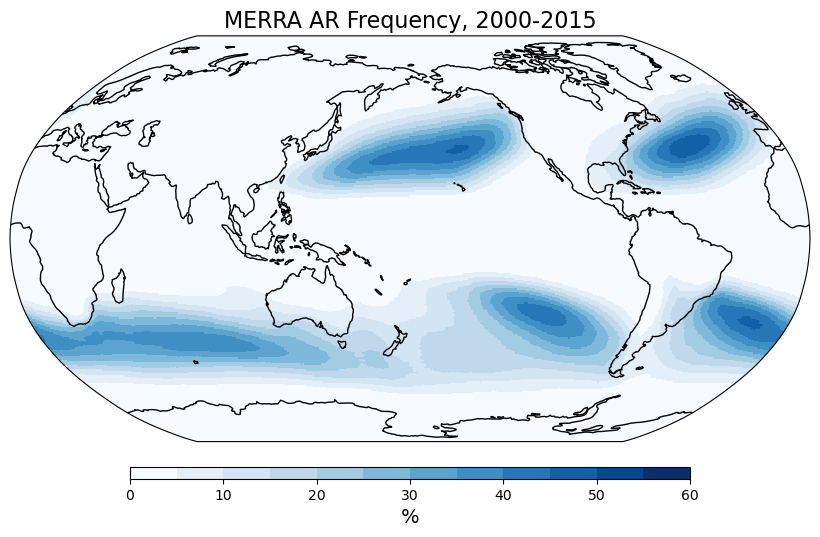

In [59]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 12)
vmax=60

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.Robinson(central_longitude=180.0))

lat = npercentARs.lat
lon = npercentARs.lon
pc = ax.pcolormesh(lon, lat, npercentARs, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())

ax.coastlines()

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.1, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
#cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal', extend='max')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('MERRA AR Frequency, 2000-2015', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_MERRA2_tier1_2000-2015.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_MERRA2_tier2_2000-2015.png', bbox_inches='tight')

## Regional heatmap

In [35]:
npercentARs.lon

<xarray.DataArray 'lon' (lon: 576)>
array([-180.   , -179.375, -178.75 , ...,  178.125,  178.75 ,  179.375],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

In [36]:
lat_bounds = slice(25,65)
lon_bounds = slice(-180,-110) # MERRA convention

In [37]:
npercentARs_WUS = npercentARs.sel(lat=lat_bounds, lon=lon_bounds)
npercentARs_WUS

<xarray.DataArray 'ar_binary_tag' (lat: 81, lon: 113)>
dask.array<getitem, shape=(81, 113), dtype=float64, chunksize=(81, 113), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 25.0 25.5 26.0 26.5 27.0 ... 63.0 63.5 64.0 64.5 65.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... -111.2 -110.6 -110.0

/glade/derecho/scratch/kdagon/tmp/ipykernel_18709/2054930753.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 8)


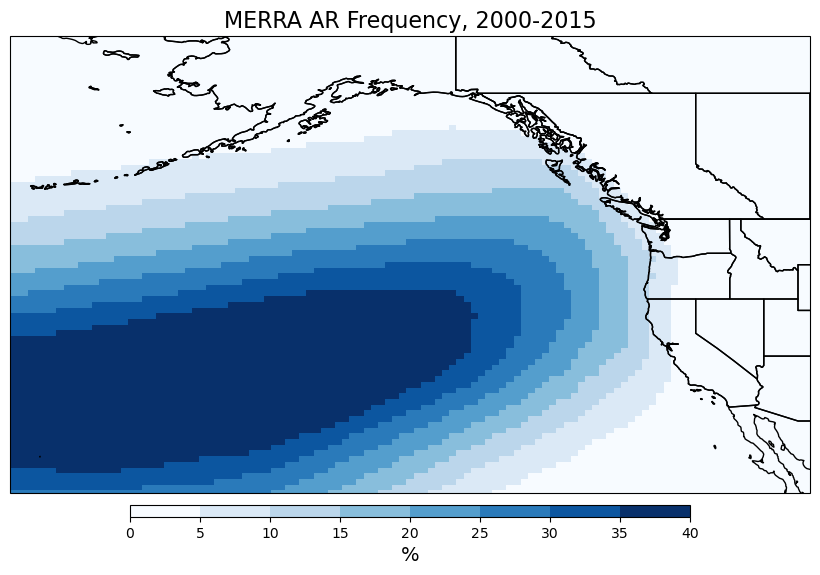

In [43]:
# a nicer plot
fig = plt.figure(figsize=(8,6))

cmap=plt.cm.get_cmap('Blues', 8)

ax = fig.add_axes([0.,0.,1.,1.], projection=ccrs.PlateCarree(central_longitude=180.0))

lat = npercentARs_WUS.lat
lon = npercentARs_WUS.lon
pc = ax.pcolormesh(lon, lat, npercentARs_WUS, cmap=cmap, vmin=0, vmax=40, transform=ccrs.PlateCarree())

# helps prevent white space at edges
ax.set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

ax.coastlines(zorder=1)
ax.add_feature(cfeature.BORDERS, zorder=2) # duplicative?
ax.add_feature(cfeature.STATES, zorder=3)

# add colorbar
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])
cbar = plt.colorbar(pc, cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
ax.set_title('MERRA AR Frequency, 2000-2015', fontsize=16); 

#plt.savefig('../figures/toSCP/npercentARs_WUS_MERRA2_tier1_2000-2015.png', bbox_inches='tight')

## Seasonal heatmap

In [71]:
season_lengths = merra_ar.time.groupby('time.season').count()
season_lengths

<xarray.DataArray 'time' (season: 4)>
array([27192, 27472, 27968, 26936])
Coordinates:
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'
Attributes:
    standard_name:  time
    axis:           T
    long_name:      time

In [72]:
npercentARs_byseason = 100*(merra_ar.groupby('time.season').sum(dim='time'))/season_lengths
npercentARs_byseason

<xarray.DataArray (season: 4, lat: 361, lon: 576)>
dask.array<truediv, shape=(4, 361, 576), dtype=float64, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [73]:
npercentARs_byseason_WUS = npercentARs_byseason.sel(lat=lat_bounds, lon=lon_bounds)

/glade/derecho/scratch/kdagon/tmp/ipykernel_18709/1815655.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Blues', 12) # ARTMIP region


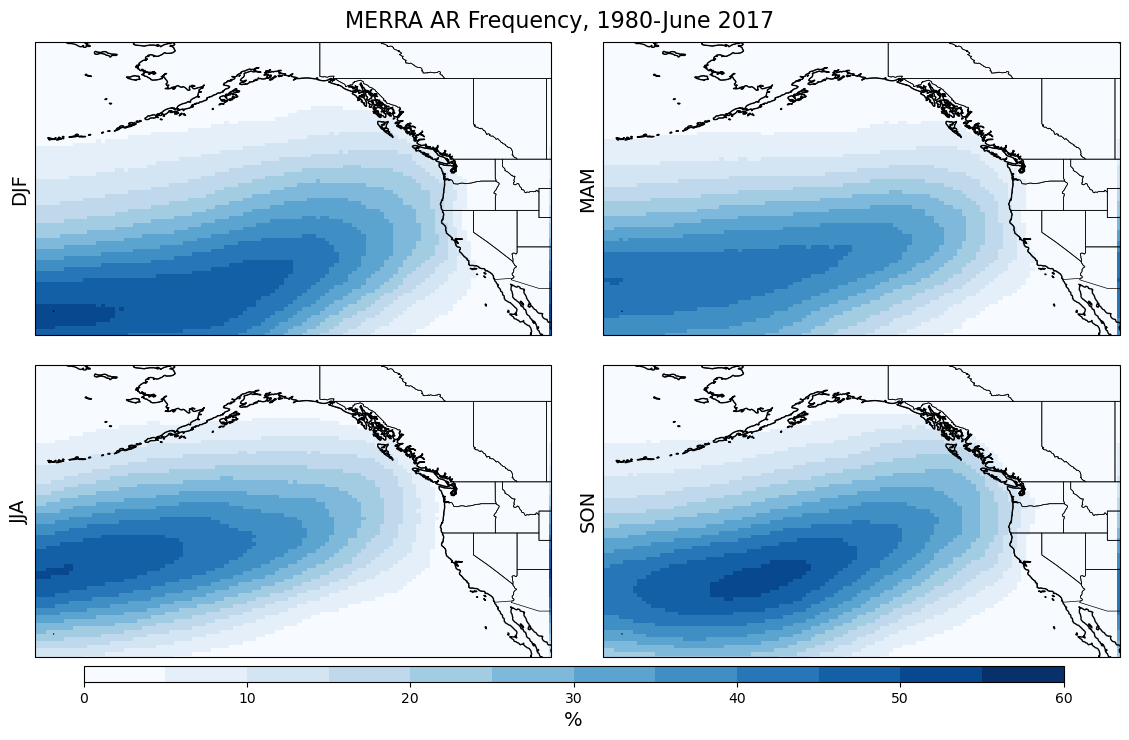

In [74]:
# a nicer plot
fig, axs = plt.subplots(2, 2, figsize=(14,8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180.0)}) # ARTMIP region

axs = axs.ravel()

# discrete colormap
cmap=plt.cm.get_cmap('Blues', 12) # ARTMIP region

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    field, lon = add_cyclic_point(npercentARs_byseason_WUS.sel(season=season), coord=npercentARs_byseason_WUS.lon)
    lat = npercentARs_byseason_WUS.lat
    cf = axs[i].pcolormesh(lon, lat, field, cmap=cmap, vmin=0, vmax=60, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.STATES, zorder=2, linewidth=0.5)
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    axs[i].set_extent((lon[0],lon[-1],lat[0],lat[-1]), crs=ccrs.PlateCarree())

# add colorbar
cb_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar = plt.colorbar(cf, cax=cb_ax, orientation='horizontal')
cbar.ax.set_xlabel('%', fontsize=14)

# add title
#fig.suptitle('MERRA AR Frequency, 2000-2015', fontsize=16, y=0.92)
fig.suptitle('MERRA AR Frequency, 1980-June 2017', fontsize=16, y=0.92)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/npercentARs_WUS_MERRA2_tier1_2000-2015_byseason.png', bbox_inches='tight')
#plt.savefig('../figures/toSCP/npercentARs_WUS_MERRA2_tier1_1980-2017_byseason.png', bbox_inches='tight')

## MERRA input variables path

In [57]:
#merra_data_path = "/glade/campaign/collections/cdg/data/ARTMIP/merra2_2000-2017/" # no time coordinate information in these files
merra_data_path = "/glade/campaign/collections/cdg/data/ARTMIP/FULL_2D_MERRA2/" # yearly folders; time as "record" dimension

In [53]:
#merra_data_files = "*.nc" # ideally subset for 2000-2015...but can't figure out how to do that with a single wildcard so split into two
#merra_data_files_1 = "*200[0-9]*" # 2000-2009
#merra_data_files_2 = "*_201[0-5]*" # 2010-2015

merra_data_files = "2000/*.nc"

### Preprocessing function to subset variables

In [59]:
def preprocess_IWV(ds):
    #ds = ds.expand_dims(time = [datetime.now()]) # add an arbitrary date?
    return ds['IWV']

## Read in data
NOTE: these files do not have a time coordinate! Which is also why time chunking isn't working...

In [61]:
%%time
merra_dataset = xr.open_mfdataset(merra_data_path+merra_data_files, concat_dim='record', combine='nested', chunks={'record':500}, parallel=True, preprocess=preprocess_IWV)
merra_dataset

#merra_dataset_1 = xr.open_mfdataset(merra_data_path+merra_data_files_1, concat_dim='time', combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_IWV)
#merra_dataset_1

CPU times: user 12.8 ms, sys: 4.01 ms, total: 16.8 ms
Wall time: 61.4 ms


<xarray.DataArray 'IWV' (record: 2928, lat: 361, lon: 576)>
dask.array<open_dataset-IWV, shape=(2928, 361, 576), dtype=float32, chunksize=(500, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Dimensions without coordinates: record
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV

In [62]:
merra_dataset.record

<xarray.DataArray 'record' (record: 2928)>
array([   0,    1,    2, ..., 2925, 2926, 2927])
Dimensions without coordinates: record

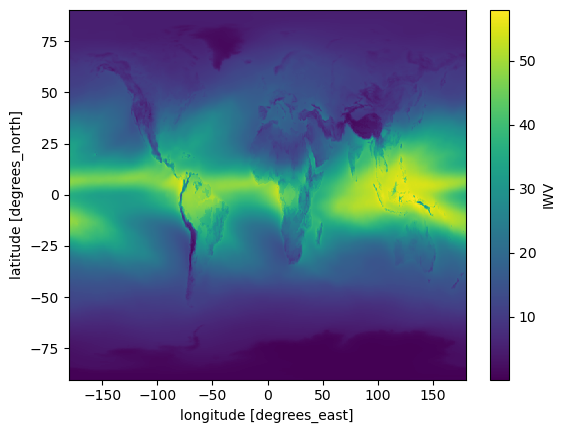

In [64]:
merra_dataset.mean(dim='record').plot();

In [33]:
merra_dataset_2 = xr.open_mfdataset(merra_data_path+merra_data_files_2, concat_dim='time', combine='nested', parallel=True, preprocess=preprocess_IWV)
merra_dataset_2

<xarray.DataArray 'IWV' (time: 17528, lat: 361, lon: 576)>
dask.array<concatenate, shape=(17528, 361, 576), dtype=float32, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
Dimensions without coordinates: time
Attributes:
    time:            0
    lev:             1000.0
    _ChunkSizes:     [  1   1  91 144]
    valid_range:     [-1.e+15  1.e+15]
    vmin:            -1000000000000000.0
    vmax:            1000000000000000.0
    standard_name:   eastward_wind
    fmissing_value:  1000000000000000.0
    units:           mm
    long_name:       Integrated Water Vapor
    short_name:      IWV

In [34]:
IWV_merra = xr.concat(merra_dataset_1, merra_dataset_2, dim='time')
IWV_merra

TypeError: concat() got multiple values for argument 'dim'

## CESM input variables path

In [10]:
cesm_data_path = "/glade/campaign/cgd/ccr/kdagon/cgnet/"

In [11]:
hist_folder = "B20TRC5CN/"
rcp26_folder = "BRCP26C5CN/"

In [12]:
hist_yrs = [str(i) for i in range(2000,2006)]
rcp26_yrs = [str(i) for i in range(2006,2016)]

In [14]:
cesm_files = '*.nc'
hist_paths = [cesm_data_path+hist_folder+y+'/'+cesm_files for y in hist_yrs]
hist_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2000/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2001/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2002/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2003/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2004/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2005/*.nc']

In [17]:
rcp26_paths = [cesm_data_path+rcp26_folder+y+'/'+cesm_files for y in rcp26_yrs]
rcp26_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2006/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2007/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2008/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2009/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2010/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2011/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2012/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2013/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2014/*.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/BRCP26C5CN/2015/*.nc']

### Preprocessing function to subset variables

In [18]:
def preprocess_TMQ(ds):
    return ds['TMQ']

### Read in historical files with preprocessing function
`xr.open_mfdataset` won't take a list of paths with wildcards, so have to feed each one and then concat\
there may be a fast way with some sort of list expansion / glob ?

In [19]:
%%time
TMQ_hist_list = []
for i,f in enumerate(hist_paths):
    #print(i)    
    TMQ_hist_temp = xr.open_mfdataset(hist_paths[i], concat_dim='time', combine="nested", chunks={'time':500}, parallel=True, preprocess=preprocess_TMQ)
    TMQ_hist_list.append(TMQ_hist_temp)
TMQ_hist = xr.concat(TMQ_hist_list, dim='time')
TMQ_hist

CPU times: user 1min 36s, sys: 4.45 s, total: 1min 40s
Wall time: 3min 18s


<xarray.DataArray 'TMQ' (time: 17520, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(17520, 768, 1152), dtype=float32, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    conventions:    CF 1.0
    creation_date:  2023-02-17

### Shift time indices of 2000-2005 back 3hrs to avoid duplicative index

In [21]:
timeshift = TMQ_hist.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"h")

In [22]:
timeshift

CFTimeIndex([2000-01-01 00:00:00, 2000-01-01 03:00:00, 2000-01-01 06:00:00,
             2000-01-01 09:00:00, 2000-01-01 12:00:00, 2000-01-01 15:00:00,
             2000-01-01 18:00:00, 2000-01-01 21:00:00, 2000-01-02 00:00:00,
             2000-01-02 03:00:00,
             ...
             2005-12-30 18:00:00, 2005-12-30 21:00:00, 2005-12-31 00:00:00,
             2005-12-31 03:00:00, 2005-12-31 06:00:00, 2005-12-31 09:00:00,
             2005-12-31 12:00:00, 2005-12-31 15:00:00, 2005-12-31 18:00:00,
             2005-12-31 21:00:00],
            dtype='object', length=17520, calendar='noleap', freq='3h')

In [23]:
TMQ_hist_final = TMQ_hist.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).assign_coords(time=timeshift)
TMQ_hist_final

<xarray.DataArray 'TMQ' (time: 17520, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(17520, 768, 1152), dtype=float32, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2000-01-01 00:00:00 ... 2005-12-31 21:00:00
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    conventions:    CF 1.0
    creation_date:  2023-02-17

### Read in RCP26

In [24]:
%%time
TMQ_rcp26_list = []
for i,f in enumerate(rcp26_paths):
    #print(i)    
    TMQ_rcp26_temp = xr.open_mfdataset(rcp26_paths[i], concat_dim='time', combine="nested", chunks={'time':500}, parallel=True, preprocess=preprocess_TMQ)
    TMQ_rcp26_list.append(TMQ_rcp26_temp)
TMQ_rcp26 = xr.concat(TMQ_rcp26_list, dim='time')
TMQ_rcp26

CPU times: user 2min 35s, sys: 7.01 s, total: 2min 42s
Wall time: 5min 33s


<xarray.DataArray 'TMQ' (time: 29200, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(29200, 768, 1152), dtype=float32, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2006-01-01 00:00:00 ... 2015-12-31 21:00:00
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
Attributes:
    long_name:     Total (vertically integrated) precipitable water
    units:         kg/m2
    cell_methods:  time: mean

### Combine historical/rcp2.6

In [25]:
TMQ_cesm = xr.concat([TMQ_hist_final, TMQ_rcp26], dim='time')
TMQ_cesm

<xarray.DataArray 'TMQ' (time: 46720, lat: 768, lon: 1152)>
dask.array<concatenate, shape=(46720, 768, 1152), dtype=float32, chunksize=(1, 768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 2000-01-01 00:00:00 ... 2015-12-31 21:00:00
Attributes:
    long_name:      Total (vertically integrated) precipitable water
    units:          kg/m2
    title:          3-hr averaged/vertically integrated/CESM Water Vapor
    summary:        Create input for ClimateNet application
    creator:        Teagan King, tking@ucar.edu
    contact:        Teagan King, tking@ucar.edu
    script:         jupyter notebook at /glade/u/home/tking/cgnet/Data_Proces...
    conventions:    CF 1.0
    creation_date:  2023-02-17

## Comparing MERRA / CESM
Spatial resolutions are different so would need to remap to make difference plots

### Annual means across 2000-2015
More sophisticated time averaging (e.g., seasonal) would require adding a time coordinate to MERRA data

In [66]:
# for now, take means separately by time period since I can't concat the files without a specific time coordinate
#IWV_merra_mean_1 = merra_dataset_1.mean(dim='time')
#IWV_merra_mean_2 = merra_dataset_2.mean(dim='time')

#IWV_merra_mean = (IWV_merra_mean_1 + IWV_merra_mean_2) / 2
#IWV_merra_mean

# temp look at 2000 only since these files are a pain to process
IWV_merra_mean = merra_dataset.mean(dim='record')

In [42]:
TMQ_cesm_mean = TMQ_cesm.mean(dim='time')
TMQ_cesm_mean

<xarray.DataArray 'TMQ' (lat: 768, lon: 1152)>
dask.array<mean_agg-aggregate, shape=(768, 1152), dtype=float32, chunksize=(768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7

/glade/work/kdagon/conda-envs/PEx_v2/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 43.89 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Text(0.5, 0, 'kg/m^2')

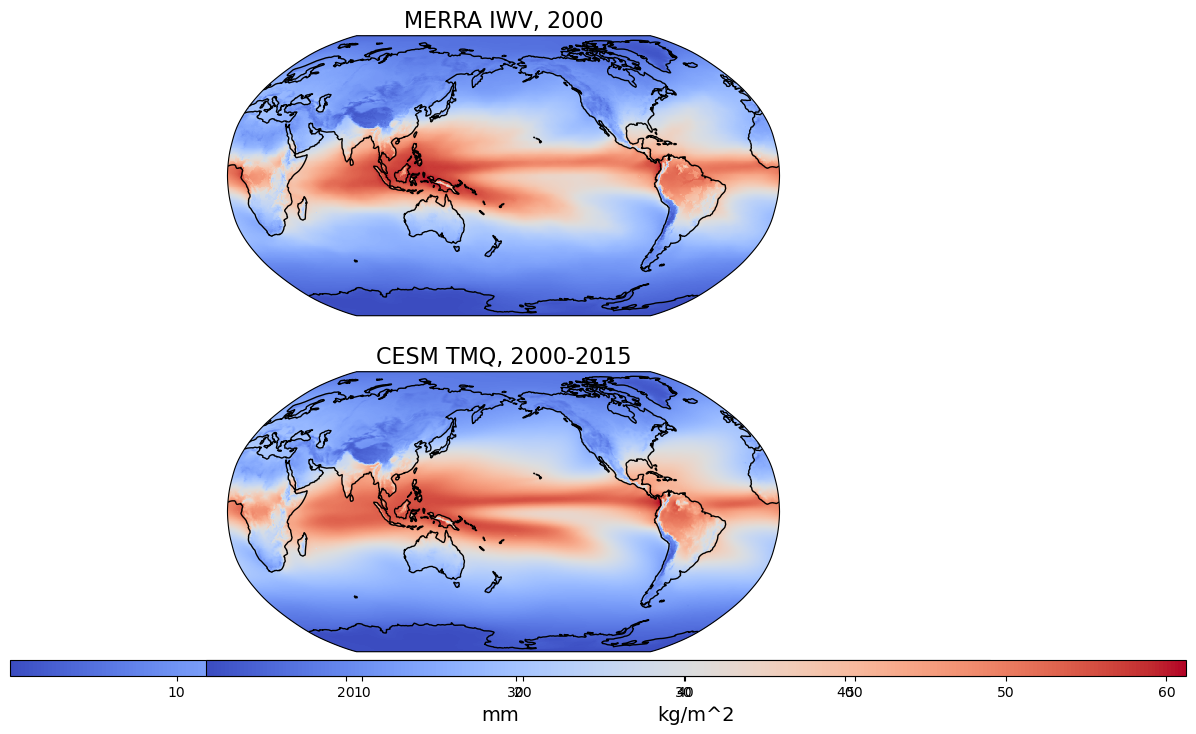

In [67]:
fig, axs = plt.subplots(2, 1, figsize=(14,8), subplot_kw={'projection': ccrs.Robinson(central_longitude=180.0)})

axs = axs.ravel()

cmap = mpl.colormaps.get_cmap('coolwarm')

# MERRA IWV [mm]
lat = IWV_merra_mean.lat
lon = IWV_merra_mean.lon
pc1 = axs[0].pcolormesh(lon, lat, IWV_merra_mean, cmap=cmap, transform=ccrs.PlateCarree())
axs[0].coastlines()
axs[0].set_title('MERRA IWV, 2000', fontsize=16)

# add colorbar
cb1_ax = fig.add_axes([0.16, 0.08, 0.7, 0.02])
cbar1 = plt.colorbar(pc1, cax=cb1_ax, orientation='horizontal')
cbar1.ax.set_xlabel('mm', fontsize=14)

# CESM TMQ [kg/m^2]
lat = TMQ_cesm_mean.lat
lon = TMQ_cesm_mean.lon
pc2 = axs[1].pcolormesh(lon, lat, TMQ_cesm_mean, cmap=cmap, transform=ccrs.PlateCarree())
axs[1].coastlines()
axs[1].set_title('CESM TMQ, 2000-2015', fontsize=16)

# add colorbar
cb2_ax = fig.add_axes([0.3, 0.08, 0.7, 0.02])
cbar2 = plt.colorbar(pc2, cax=cb2_ax, orientation='horizontal')
cbar2.ax.set_xlabel('kg/m^2', fontsize=14)

# add title
#fig.suptitle('', fontsize=16, y=0.92)

#plt.subplots_adjust(wspace=0.1, hspace=0.1)

#plt.savefig('../figures/toSCP/.png', bbox_inches='tight')

In [68]:
client.close()
cluster.close()